In [3]:
%matplotlib inline
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import metrics
# Helper Functions
from helpers import *

In [9]:
def sift(img_block, img_slide):
    # Check for similarities between the 2 images
    sift = cv2.xfeatures2d.SIFT_create()
    kp_1, desc_1 = sift.detectAndCompute(img_block, None)
    kp_2, desc_2 = sift.detectAndCompute(img_slide, None)

    index_params = dict(algorithm=0, trees=5)
    search_params = dict()
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(desc_1, desc_2, k=2)

    good_points = []
    for m, n in matches:
        if m.distance < 0.7*n.distance:
            good_points.append(m)

    # Define how similar they are
    number_keypoints = 0
    if len(kp_1) <= len(kp_2):
        number_keypoints = len(kp_1)
    else:
        number_keypoints = len(kp_2)

    print('=========== SIFT ===========')
    print("Keypoints 1ST Image: " + str(len(kp_1)))
    print("Keypoints 2ND Image: " + str(len(kp_2)))
    print("GOOD Matches:", len(good_points))
    print("How good it's the match: ", len(good_points) / number_keypoints)

    result = cv2.drawMatches(
        img_block, kp_1, img_slide, kp_2, good_points, None)
    show1img('result',result)



def compare_hist(img_block, img_slide):
    # images: it is the source image of type uint8 or float32. it should be given in square brackets, ie, "[img]".
    # channels: it is also given in square brackets. It is the index of channel for which we calculate histogram. For example, if input is grayscale image, its value is [0]. For color image, you can pass [0], [1] or [2] to calculate histogram of blue, green or red channel respectively.
    # mask: mask image. To find histogram of full image, it is given as "None". But if you want to find histogram of particular region of image, you have to create a mask image for that and give it as mask. (I will show an example later.)
    # histSize: this represents our BIN count. Need to be given in square brackets. For full scale, we pass [256].
    # ranges: this is our RANGE. Normally, it is [0, 256].

    # Use the 0-th and 1-st channels
    channels = [0]
    histSize = [256]
    ranges = [0, 256]

    hist_block = cv2.calcHist(images=[img_block],
                              channels=channels,
                              mask=None,
                              histSize=histSize,
                              ranges=ranges)

    cv2.normalize(hist_block, hist_block, alpha=0,
                  beta=1, norm_type=cv2.NORM_MINMAX)

    hist_slide = cv2.calcHist(images=[img_slide],
                              channels=channels,
                              mask=None,
                              histSize=histSize,
                              ranges=ranges,
                              accumulate=False)

    cv2.normalize(hist_slide, hist_slide, alpha=0,
                  beta=1, norm_type=cv2.NORM_MINMAX)

#     methods = {
#         0: 'Correlation',
#         1: 'Chi-Square',
#         2: 'Intersection',
#         3: 'Bhattacharyya distance'
#     }

#     print('=========== Compare Histograms ===========')
#     for compare_method in range(4):
#         block_block = cv2.compareHist(hist_block, hist_block, compare_method)
#         block_slide = cv2.compareHist(hist_block, hist_slide, compare_method)

#         print('Method:', methods[compare_method])
#         print('   block-block match: ', block_block)
#         print('   block-slide match:',  block_slide)
        
    score_corr = cv2.compareHist(hist_block, hist_slide, 0)
    score_chi = 1 - cv2.compareHist(hist_block, hist_slide, 1)
    score_inter = cv2.compareHist(hist_block, hist_slide, 2) / cv2.compareHist(hist_block, hist_block, 2)
    score_bhat = 1 -cv2.compareHist(hist_block, hist_slide, 3)
    return score_corr, score_chi, score_inter, score_bhat


def caluculate_mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

def caluculate_iou(image_block, image_slide):

    diff_block_slide = cv2.subtract(image_block, image_slide)
    diff_block_slide_coloured = diff_block_slide.copy()
    diff_block_slide_coloured[diff_block_slide_coloured[:, :, 0] > 10] = [0, 0, 255]


    diff_slide_block = cv2.subtract(image_slide, image_block)
    diff_slide_block_coloured = diff_slide_block.copy()
    diff_slide_block_coloured[diff_slide_block_coloured[:, :, 0] > 10] = [255, 0, 0]

#     show2img('block - slide',diff_block_slide_coloured, 'slide - block', diff_slide_block_coloured)

    diff = cv2.add(diff_block_slide, diff_slide_block)
    diff_coloured = cv2.add(diff_block_slide_coloured, diff_slide_block_coloured)
#     show1img('diff_coloured',diff_coloured)

    union = cv2.add(image_block, image_slide)
#     show1img('union',union)

    intersection = cv2.subtract(union, diff)
#     show2img('intersection',intersection, 'diff',  diff_coloured)

    viz = cv2.addWeighted(diff_coloured, 0.7, intersection, 0.5, 0)
    show1img('overlay',viz)

    n_white_pix_union = np.sum(union > 0)
    n_white_pix_intersection = np.sum(intersection > 0)
    n_white_pix_difference = np.sum(diff > 0)
    
    score = n_white_pix_intersection/n_white_pix_union
    
#     print('=========== Intersection over Union ===========')
#     print("IoU: %.2f" % score)
    
    return score

from sklearn.metrics import jaccard_similarity_score

def calculate_jaccard(image_block, image_slide):
    image_block= image_block.flatten()
    image_slide= image_slide.flatten()
    return jaccard_similarity_score(image_block, image_slide)

from scipy.spatial.distance import dice

def calculate_dice(image_block, image_slide):
    image_block_bool = image_block.copy()
    image_slide_bool = image_slide.copy()

    image_block_bool[image_block_bool>0]= 1
    image_slide_bool[image_slide_bool>0]= 1
    image_block_bool= image_block_bool.flatten()
    image_slide_bool= image_slide_bool.flatten()
    return 1 - dice(image_block_bool, image_slide_bool)

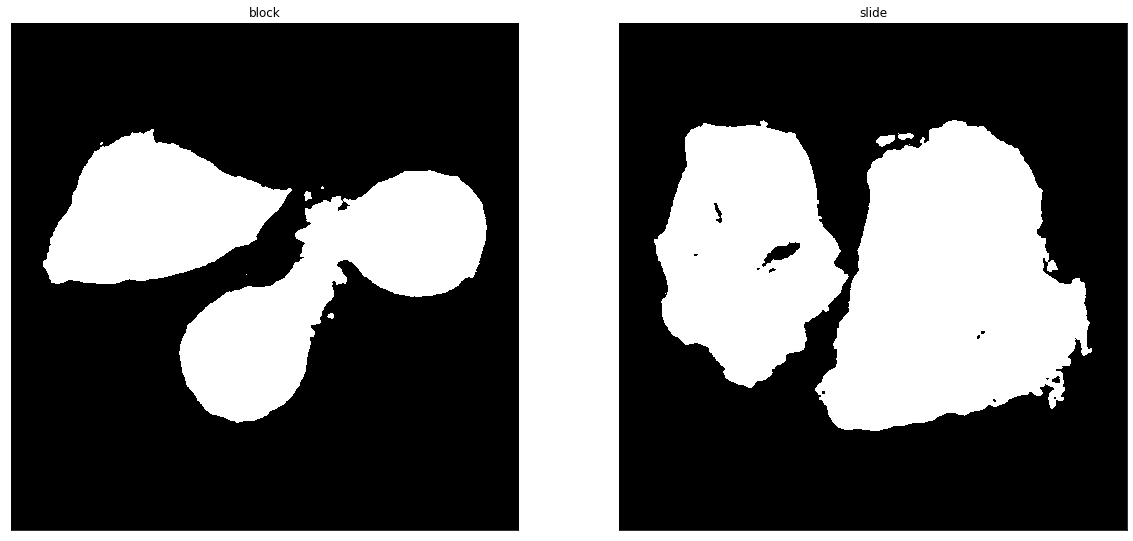

In [7]:
str_path_block = './data/img_clean/blocks_thres/'
str_file_block = '_DSC9676.JPG'
str_path_slide = './data/img_clean/slides_thres/'
str_file_slide = '_DSC7204.JPG'

# image_block = cv2.cvtColor(cv2.imread(str_path_block + str_file_block), cv2.COLOR_BGR2GRAY)
# image_slide = cv2.cvtColor(cv2.imread(str_path_slide + str_file_slide), cv2.COLOR_BGR2GRAY)

image_block = cv2.imread(str_path_block + str_file_block)
image_slide = cv2.imread(str_path_slide + str_file_slide)

show2img('block', image_block, 'slide',image_slide)

In [6]:
score_mse = caluculate_mse(image_block, image_slide)
score_ssim = metrics.structural_similarity(image_block, image_slide,multichannel=True)
score_corr, score_chi, score_inter, score_bhat = compare_hist(image_block, image_slide)
score_iou = caluculate_iou(image_block, image_slide)
score_jaccard = calculate_jaccard(image_block, image_slide)
score_dice = calculate_dice(image_block, image_slide)
print("MSE:                              %.6f" % score_mse)
print("SSIM:                             %.6f" % score_ssim)
print("Histogram correlation:            %.6f" % score_corr)
print("Histogram chi square:             %.6f" % score_chi)
print("Histogram intersection:           %.6f" % score_inter)
print("Histogram Bhattacharyya distance: %.6f" % score_bhat)
print("Intersection-over-Union1:         %.6f" % score_iou)
print("Intersection-over-Union2:         %.6f" % score_jaccard)
print("Dice:                             %.6f" % score_dice)

MSE:                              8229.937008
SSIM:                             0.935036
Histogram correlation:            0.999226
Histogram chi square:             0.861843
Histogram intersection:           0.999363
Histogram Bhattacharyya distance: 0.953551
Intersection-over-Union1:         0.836411
Intersection-over-Union2:         0.941241
Dice:                             0.910919


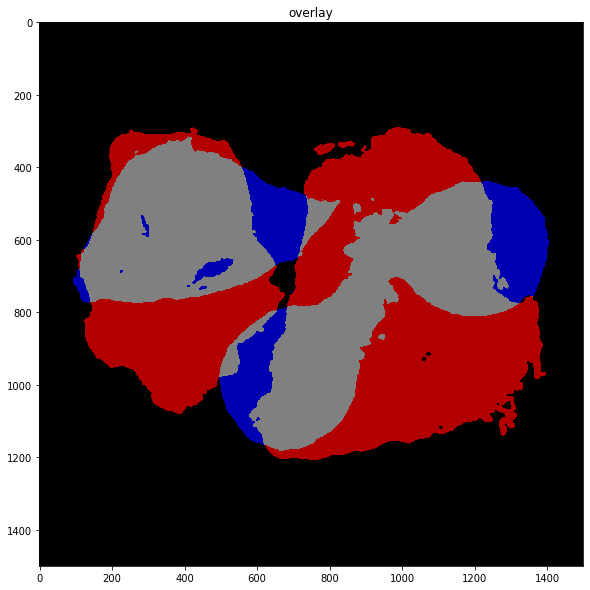

MSE:                              44418.462392
SSIM:                             0.748991
Histogram chi square:             0.743891
Histogram Bhattacharyya distance: 0.894401
Intersection-over-Union1:         0.448633
Intersection-over-Union2:         0.760172
Dice:                             0.619388


In [10]:
score_mse = caluculate_mse(image_block, image_slide)
score_ssim = metrics.structural_similarity(image_block, image_slide,multichannel=True)
score_corr, score_chi, score_inter, score_bhat = compare_hist(image_block, image_slide)
score_iou = caluculate_iou(image_block, image_slide)
score_jaccard = calculate_jaccard(image_block, image_slide)
score_dice = calculate_dice(image_block, image_slide)
print("MSE:                              %.6f" % score_mse)
print("SSIM:                             %.6f" % score_ssim)
print("Histogram chi square:             %.6f" % score_chi)
print("Histogram Bhattacharyya distance: %.6f" % score_bhat)
print("Intersection-over-Union1:         %.6f" % score_iou)
print("Intersection-over-Union2:         %.6f" % score_jaccard)
print("Dice:                             %.6f" % score_dice)